In [5]:
from matplotlib import pyplot as plt 
import cv2
import numpy as np
import scipy.ndimage

import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

In [2]:
def generate_density_map(image, points, sigma=15):
    height, width = image.shape[:2]
    density_map = np.zeros((height, width), dtype=np.float32)

    for x, y in points:
        if x >= width or y >= height:  # Ignore points out of bounds
            continue
        density_map[y, x] = 1  # Mark head position

    # Apply Gaussian filter to simulate density
    density_map = scipy.ndimage.gaussian_filter(density_map, sigma=sigma, mode='constant')
    
    return density_map


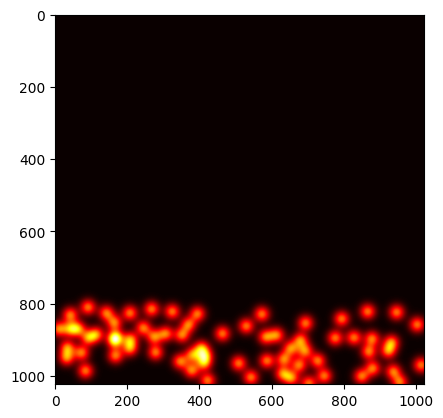

: 

In [9]:
image = cv2.imread('Train_resized/img_0001_crop_0.jpg')
mat = scipy.io.loadmat('Train_resized/img_0001_crop_0.mat')
points = mat["annPoints"]
points = points.astype(int)

density_map = generate_density_map(image, points)
plt.imshow(density_map, cmap='hot')

In [9]:
class CrowdCounterResNet(nn.Module):
    def __init__(self):
        super(CrowdCounterResNet, self).__init__()

        # Load pretrained ResNet-50 and cut off the classification head
        resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 2048, H/32, W/32)

        # Decoder: Upsample to match original image size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1),  # (H/16, W/16)
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),   # (H/8, W/8)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),   # (H/4, W/4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),    # (H/2, W/2)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),      # (H, W)
            nn.ReLU()  # Optional: clip negative values
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.decoder(x)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CrowdCounterResNet().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Adil/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [8]:
class CrowdDataset(Dataset):
    def __init__(self, image_paths, heatmap_paths, transform=None, heatmap_transform=None):
        self.image_paths = image_paths
        self.heatmap_paths = heatmap_paths
        self.transform = transform or T.ToTensor()
        self.heatmap_transform = heatmap_transform or T.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)

        # Load heatmap
        heatmap = Image.open(self.heatmap_paths[idx]).convert('L')  # Grayscale
        heatmap = self.heatmap_transform(heatmap).float() / 255.0

        return img, heatmap

In [12]:
train_resized_folder = "Train_resized"
train_density_folder = "Train_density"

train_image_paths = []
train_heatmap_paths = []

# Iterate over files in Train_resized folder
for file_name in os.listdir(train_resized_folder):
    if file_name.endswith(".jpg"):
        train_image_paths.append(os.path.join(train_resized_folder, file_name))

# Iterate over files in Train_density folder
for file_name in os.listdir(train_density_folder):
    if file_name.endswith(".jpg"):
        train_heatmap_paths.append(os.path.join(train_density_folder, file_name))

print(f"Found {len(train_image_paths)} images and {len(train_heatmap_paths)} heatmaps.")


validation_resized_folder = "Validation_resized"
validation_density_folder = "Validation_density"
validation_image_paths = []
validation_heatmap_paths = []

# Iterate over files in Validation_resized folder
for file_name in os.listdir(validation_resized_folder):
    if file_name.endswith(".jpg"):
        validation_image_paths.append(os.path.join(validation_resized_folder, file_name))

# Iterate over files in Validation_density folder
for file_name in os.listdir(validation_density_folder):
    if file_name.endswith(".jpg"):
        validation_heatmap_paths.append(os.path.join(validation_density_folder, file_name))

print(f"Found {len(validation_image_paths)} images and {len(validation_heatmap_paths)} heatmaps.")

Found 4804 images and 4804 heatmaps.
Found 668 images and 668 heatmaps.


In [13]:
train_dataset = CrowdDataset(train_image_paths, train_heatmap_paths)
validation_dataset = CrowdDataset(validation_image_paths, validation_heatmap_paths)

In [11]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-5, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, targets in val_loader:
                    images = images.to(device)
                    targets = targets.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * images.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

    return model


In [14]:
model = CrowdCounterResNet()

# Assuming you have these ready
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

trained_model = train_model(model, train_loader, val_loader, num_epochs=25)

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
